# Rank Boosted Classifier on Pancreas Dataset

In [1]:
import numpy as np
import pandas as  pd
import scanpy as sc
from sklearn.linear_model import LinearRegression

## Read the data

In [2]:
## Read train data
adata_train = sc.read('/home/namratab/namratab/TransferLearning/trancellvec/data/pancreas/Bh.h5ad')
adata_train

AnnData object with n_obs × n_vars = 8569 × 20125
    obs: 'celltype'

In [3]:
adata_train.obs.celltype.value_counts()

beta                  2525
alpha                 2326
ductal                1077
acinar                 958
delta                  601
activated_stellate     284
gamma                  255
endothelial            252
quiescent_stellate     173
macrophage              55
mast                    25
epsilon                 18
schwann                 13
t_cell                   7
Name: celltype, dtype: int64

In [4]:
adata_test = sc.read('/home/namratab/namratab/TransferLearning/trancellvec/data/pancreas/smartseq2.h5ad')
adata_test

AnnData object with n_obs × n_vars = 2394 × 34363
    obs: 'celltype', 'tech'
    var: 'genename'

In [5]:
adata_test.obs.celltype.value_counts()

alpha                 1008
ductal                 444
beta                   308
gamma                  213
acinar                 188
delta                  127
activated_stellate      55
endothelial             21
epsilon                  8
macrophage               7
mast                     7
quiescent_stellate       6
schwann                  2
Name: celltype, dtype: int64

In [3]:
# To make it into the ideal use-case, use only those label in the train data that are present in the test data
minority_classes = ['acinar',
 'activated_stellate',
 'alpha',
 'beta',
 'delta',
 'ductal',
 'endothelial',
 'epsilon',
 'gamma',
 'macrophage',
 'mast',
 'quiescent_stellate',
 'schwann']       # get the minority classes
adata_train = adata_train[adata_train.obs.celltype.isin(minority_classes)]

<AxesSubplot:>

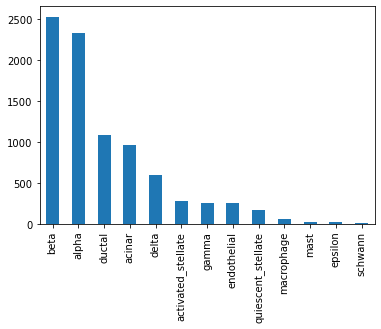

In [4]:
adata_train.obs.celltype.value_counts().plot(kind='bar')

In [5]:
adata_test = sc.read('/home/namratab/namratab/TransferLearning/trancellvec/data/pancreas/smartseq2.h5ad')
adata_test

AnnData object with n_obs × n_vars = 2394 × 34363
    obs: 'celltype', 'tech'
    var: 'genename'

<AxesSubplot:>

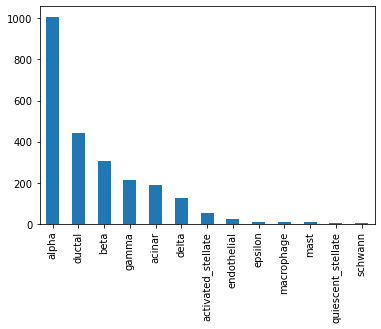

In [12]:
adata_test.obs.celltype.value_counts().plot(kind='bar')

In [13]:
adata_test.shape, adata_train.shape

((2394, 34363), (8562, 20125))

## Taking common genes before preprocessing

In [14]:
adata_concat = adata_train.concatenate(adata_test,batch_key='batch', batch_categories= ['train','test'])
adata_concat

/home/namratab/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 10956 × 19612
    obs: 'celltype', 'tech', 'batch'
    var: 'genename-test'

## Pre-processing

In [15]:
# Preprocess the test data
adata_test.obs_names_make_unique()
adata_test.var_names_make_unique()
sc.pp.filter_cells(adata_test, min_genes=200)
sc.pp.filter_genes(adata_test, min_cells=20)
sc.pp.normalize_total(adata_test, target_sum=1e4)
sc.pp.log1p(adata_test)
sc.pp.highly_variable_genes(adata_test, n_top_genes = 3000)
adata_test = adata_test[:, adata_test.var.highly_variable]
sc.pp.scale(adata_test, max_value=10)
adata_test.shape

/home/namratab/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(2394, 3000)

In [16]:
# Preprocess the train data
adata_train.obs_names_make_unique()
adata_train.var_names_make_unique()
sc.pp.filter_cells(adata_train, min_genes=200)
sc.pp.filter_genes(adata_train, min_cells=20)
sc.pp.normalize_total(adata_train, target_sum=1e4)
sc.pp.log1p(adata_train)
sc.pp.highly_variable_genes(adata_train, n_top_genes = 3000)
adata_train = adata_train[:, adata_train.var.highly_variable]
sc.pp.scale(adata_train, max_value=10)
adata_train.shape

/home/namratab/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


(8562, 3000)

In [17]:
## Taking common genes after preprocessing
adata_concat = adata_train.concatenate(adata_test,batch_key='batch', batch_categories= ['train','test'])
adata_concat

/home/namratab/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 10956 × 1550
    obs: 'celltype', 'n_genes', 'tech', 'batch'
    var: 'highly_variable', 'n_cells-test', 'means-test', 'dispersions-test', 'dispersions_norm-test', 'mean-test', 'std-test', 'genename-test', 'n_cells-train', 'means-train', 'dispersions-train', 'dispersions_norm-train', 'mean-train', 'std-train'

*** 
## Get DE genes

In [75]:
sc.tl.rank_genes_groups(adata_train, groupby="celltype", method='wilcoxon')
celltypes_list = adata_train.obs.celltype.unique().tolist()
top_50_DE_genes = {c: [] for c in celltypes_list}
for c in top_50_DE_genes:
        detrain_df = sc.get.rank_genes_groups_df(adata_train, group=c).head(50)
        top_50_DE_genes[c] = detrain_df['names'].tolist()

/home/namratab/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/namratab/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/namratab/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/namratab/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/namratab/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/namratab/.local/lib/pyth

<hline>

***
## Dropout induction

In [76]:
def fit_regression(E, D):
        clf = LinearRegression()
        if (np.sum(np.isnan(E)) > 1):
                print("Error")
                return 1, 0
        if (np.sum(np.isnan(D)) > 1):
                print("Error2")
                return 1, 0
        clf.fit(np.reshape(E, (E.shape[0], 1)), D)
        return (clf.coef_, clf.intercept_)

def calc_dropout(df):
        pg = []
        for col in df:
                pg.append(np.sum(df[col] == 0)/len(df))
        pg = np.array(pg)
        return pg

def get_prob_of_less_than(val, k):
        if np.random.random() < k:
                return 0
        else:
                return val
        
def inductive_dropout(df, f=0.5):
        p_g = calc_dropout(df)
        p_g[p_g <= 0] = 1e-6
        p_g[p_g >= 1] = 1 - 1e-6
        D_g = np.log(p_g/(1-p_g))
        R_g = np.array([df[col].mean() for col in list(df.columns)])
        E_g = np.log2(R_g + 1)
        beta, alpha = fit_regression(E_g, D_g)

        E_g_prime = f * E_g
        delta_g = beta*(E_g_prime - E_g)
        D_g_prime = D_g + delta_g

        p_g_prime = 1/ (1 + np.exp(-1*D_g_prime))
        R_g_prime = np.power(2, E_g_prime) - 1

        for i in range(len(df.columns)):
                df[df.columns[i]] = df[df.columns[i]].apply(lambda x : get_prob_of_less_than(x, p_g_prime[i]-p_g[i]))
                R_g_i = np.mean(df[df.columns[i]])
#               df[df.columns[i]] += R_g_i - R_g_prime[i]
                df[df.columns[i]] *= (R_g_prime[i]/(R_g_i + 1e-4))
        return df  
    
def apply_dropout(data, celltypes, n_iter = 1, f = 0.8):
        """
        INPUT:
                data: dataframe containing cell-gene expression matrix
                n_iter: no of times to apply dropout
                f: dropout concentration
        """
        new_df = pd.DataFrame()
        celltypes = celltypes.tolist()
        new_celltypes = celltypes*(n_iter)
        for i in range(n_iter):
                data = inductive_dropout(data.copy(), f)
                new_df = pd.concat((new_df, data))
        new_df['celltype'] = new_celltypes
        return new_df

In [77]:
train_df = apply_dropout(adata_train.to_df(), adata_train.obs.celltype, 2, 0.85)
train_df

/tmp/ipykernel_1170208/399686921.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df['celltype'] = new_celltypes


index,A2M,A4GALT,AAAS,AADAC,AATK,ABCA4,ABCA8,ABCB1,ABCC3,ABCC8,...,ZNF682,ZNF684,ZNF70,ZNF703,ZSCAN9,ZSWIM3,ZSWIM4,ZYX,pk,celltype
index,,,,,,,,,,,,,,,,,,,,,
human1_lib1.final_cell_0001,-0.173396,0.003597,2.157673e-03,8.022643e-02,-4.655789e-04,-0.041929,-0.048585,-1.101480e-03,7.163140e-03,-4.752388e-03,...,-0.081127,-0.063867,-0.074535,3.519431e-04,-0.187416,2.352397,-1.035320,1.158862e-02,-8.894734e-03,acinar
human1_lib1.final_cell_0002,-0.173396,0.003597,2.157673e-03,8.334260e-02,-4.655789e-04,-0.041929,-0.048585,-1.101480e-03,7.163140e-03,-9.928713e-03,...,-0.081127,-0.063867,-0.074535,3.519431e-04,-0.187416,-0.089492,-1.035320,2.523700e-02,6.985599e-03,acinar
human1_lib1.final_cell_0003,-0.173396,0.003597,2.157673e-03,-4.170295e-03,-4.655789e-04,-0.041929,-0.048585,-1.101480e-03,7.163140e-03,-9.928713e-03,...,-0.081127,-0.063867,-0.074535,3.519431e-04,-0.187416,-0.089492,-1.035320,-2.328602e-02,6.985599e-03,acinar
human1_lib1.final_cell_0004,-0.173396,0.003597,-3.458773e-03,-4.170295e-03,-4.655789e-04,-0.041929,-0.048585,-1.101480e-03,-3.814730e-02,-9.928713e-03,...,-0.081127,-0.063867,-0.074535,3.519431e-04,-0.187416,-0.089492,-1.035320,2.794344e-02,6.985599e-03,acinar
human1_lib1.final_cell_0005,-0.173396,0.003597,2.157673e-03,-4.170295e-03,-4.655789e-04,-0.041929,-0.048585,-1.101480e-03,-2.527270e-02,-9.928713e-03,...,-0.081127,-0.063867,-0.074535,3.519431e-04,-0.187416,-0.089492,-1.035320,4.522201e-03,-1.490352e-02,acinar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
human4_lib3.final_cell_0697,6.843541,0.000001,5.213129e-10,-1.147757e-08,2.670029e-11,-0.035877,-0.041588,3.236864e-11,-1.480481e-08,8.016999e-09,...,-0.069728,-0.054738,-0.064002,-4.045713e-11,-0.180980,-0.077062,-1.072935,-1.802914e-09,-3.161529e-08,activated_stellate
human4_lib3.final_cell_0698,-0.176349,0.000001,5.213129e-10,-1.147757e-08,2.670029e-11,-0.035877,-0.041588,3.236864e-11,-1.480481e-08,8.016999e-09,...,-0.069728,-0.054738,-0.064002,-4.045713e-11,-0.180980,-0.077062,-1.072935,-1.802914e-09,-3.161529e-08,alpha
human4_lib3.final_cell_0699,-0.176349,0.000001,5.213129e-10,-1.147757e-08,2.670029e-11,-0.035877,-0.041588,3.236864e-11,-1.480481e-08,8.016999e-09,...,-0.069728,-0.054738,-0.064002,-4.045713e-11,-0.180980,-0.077062,-1.072935,-1.802914e-09,-3.161529e-08,beta


***

## Rank ordering of genes